In [2]:
import numpy as np
from scipy import ndimage, misc
from skimage import feature
from scipy.misc.pilutil import Image
from skimage.filters import threshold_local
# from scipy.ndimage import label
from skimage.measure import regionprops
from skimage.morphology import label
import scipy.ndimage as snd
from skimage import filters
import scipy.fftpack as fftim
import skimage.exposure as imexp
import scipy.misc
import matplotlib.pyplot as plt
import cv2
import png
from IPython.display import display, Math
import os

# Load all image in the directory
Don't run yet, it might take a while to load...

In [101]:
path = "/Users/edenmolina/Downloads/pics/"

# for filename in os.listdir(path):
#     image = np.array(Image.open('%s/%s'%(path, filename)).convert('L'))

# Load just one image

In [81]:
image = np.array(Image.open('/Users/edenmolina/Downloads/pics/6153.jpg').convert('L'))

# View the image

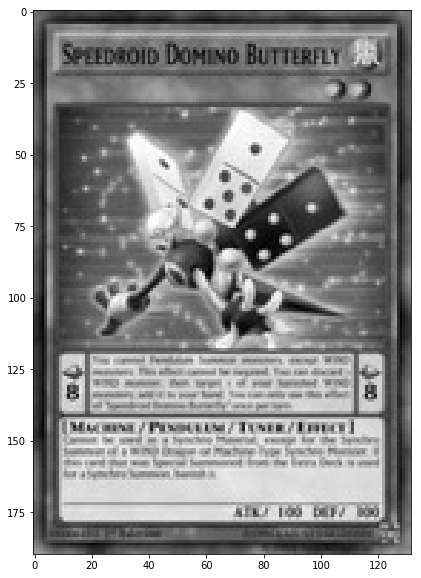

In [82]:
plt.figure(figsize = (10, 10))
plt.imshow(image, cmap = 'gray')
plt.show()

# Apply gamma-correction
This is a form of a power law transform where the pixel values in an image at position $\left( i, j \right)$ will be

$$
t(i, j) = k I(i, j)^{\gamma}
$$

We choose $k=1$ and $\gamma$ to be determined by some value that maximizes the variance (information) in the image.

In [11]:
def FindOptimalGamma(image, lower, upper, steps = 100):
    Gammas = list()
    image_n = image/np.max(image)
    for i, j in enumerate(np.linspace(lower, upper, steps)):
        image_gamma_array = np.exp(np.log(image_n)*j)*np.max(image)
        Gammas.append(tuple((j, np.std(image_gamma_array))))

    GammasArray = np.array(Gammas)
    GammasArray[np.isnan(GammasArray)] = 0


    return (GammasArray[:,0][np.argmax(GammasArray[:,1])])

In [67]:
# gamma = FindOptimalGamma(image, .1, 100, 200)
# print (gamma)
gamma = .5

# Convert image to floats
image = image.astype(float)

# Normalize the image
image_n = image / np.max(image)

# Apply the gamma transformation
image_gamma_array = np.exp(np.log(image_n)*gamma)*np.max(image)

# Set the array as integers
image_gamma_array = image_gamma_array.astype(np.uint8)

<IPython.core.display.Javascript object>


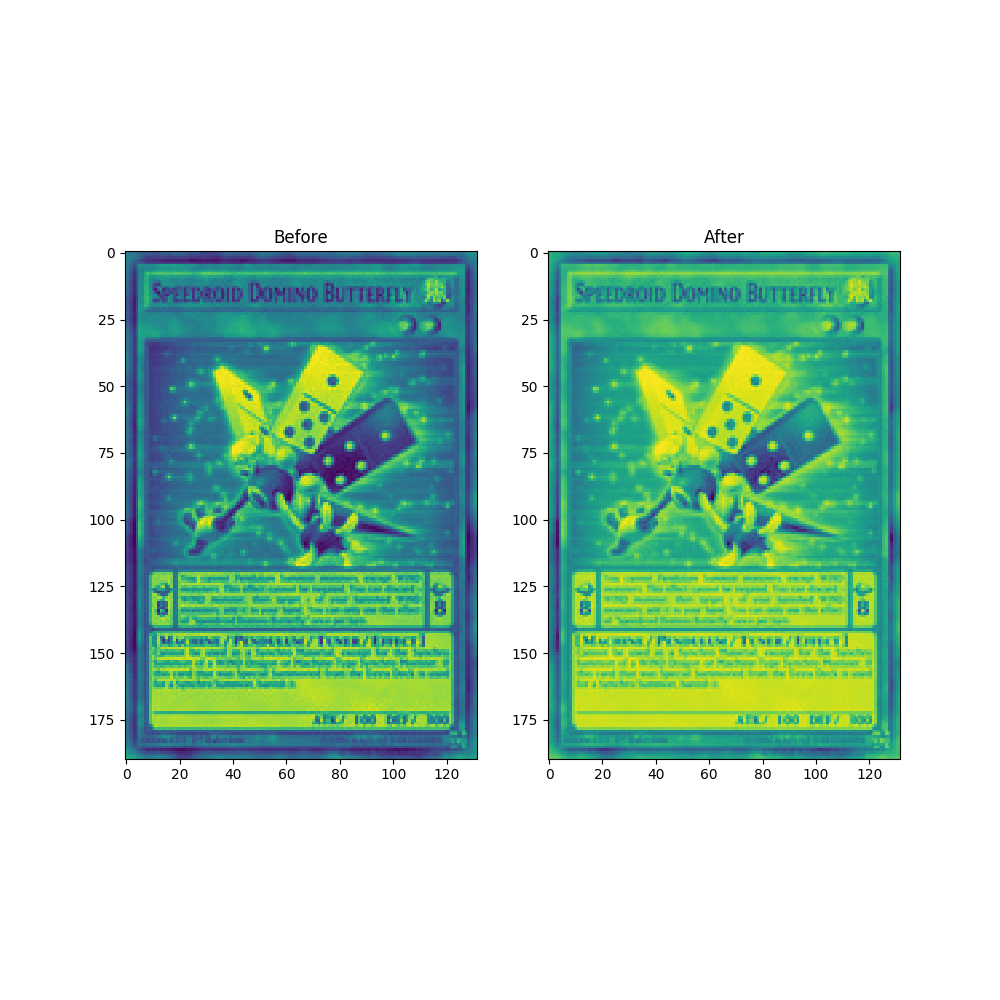

In [235]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
ax[0].imshow(image)
ax[0].title.set_text("Before")

ax[1].imshow(image_gamma_array)
ax[1].title.set_text("After")
plt.show()

# Plot histograms of image
This allows us to see the distribution of pixel intensities in the image. We can see that the image inensities got slightly shifted to the right and lowered in intensitiy in the midrange.

<IPython.core.display.Javascript object>


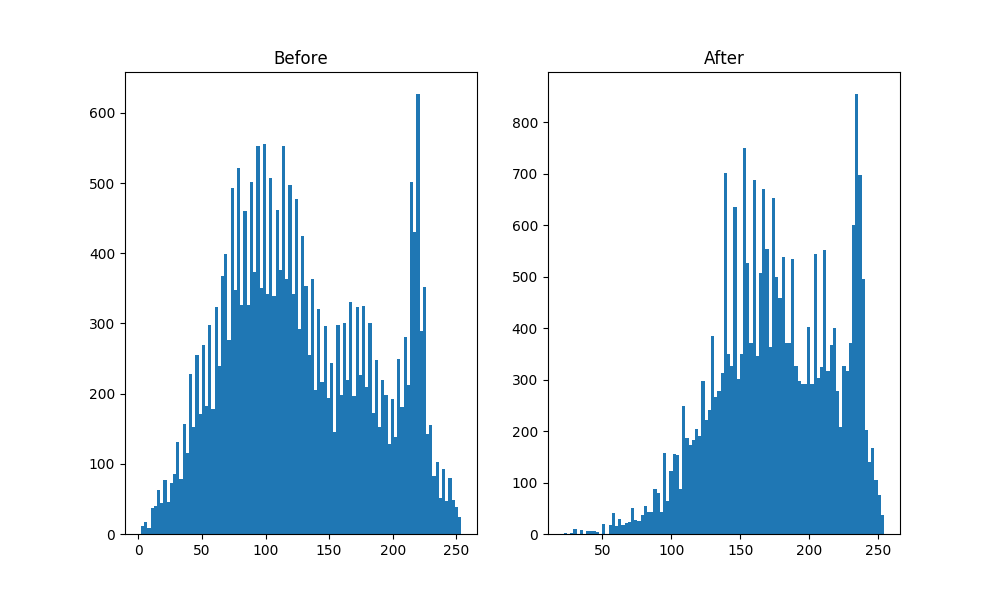

In [238]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].hist(image.flatten(), bins = 100)
ax[0].title.set_text("Before")

ax[1].hist(image_gamma_array.flatten(), bins = 100)
ax[1].title.set_text("After")
plt.show()

# Try histogram equalization
## Histrogram Equalization
The histogram of an image is a discrete fucntion, and its input is the value of the pixel and the output is the numer of pixels of that value which we can denote as $h(x_n) = y_n$. In a grayscape image, the intensities will range from $[0, L-1]$. The low gray level values in the iamge correspond to bright values.

In a low contrast image, the histogram will be narrow while in a high contrast image the histogram will be wide. The goal of histgram transformation is to rescale the histogram so that the histogram of the output image will range over all possible gray values. The rescaling of the histrogram will be performed by using a transofmation. To ensure that each gray value will be maped to another gray value, we need to ensure that our transformation is one to one-for every input there is a unique output. This implies that our transformation is an increasing function.

### Prior to performing historgram equalization we must compute:
   * The histogram of the input image is normalized so that the range of the histogram is between $[0, 1]$
   * Since the image is discrete, the probabilty of a gray value will be given by $p_x(i)$. This is the ratio of the number of pixels with gray value $i$ to the total number of pixels in the image.
   * The cummulative distribution (CDF) is defined as the equation below where $0 \leq i \leq L-1$ where $L$ is the total number of grey levels in the image.
$$
\begin{equation}
C(i) = \sum_{j=0}^{i}
\end{equation}
$$
        * Note that $C(i)$ is the num of the probabilities in the grey level values from $0$ to $i$
        
The histogram equalization transformation can be defined as:
$$
h(u) = round(\frac{C(u)-C_{min}}{10 C_{min}} * (L-1))
$$
where $C_{min}$ is the minimum cumulative distribution value in the image.

In [83]:
# Flatten the image array
image_flat = image.flatten()

In [84]:
# Compute the histogram and the bins of the image
hist, bins = np.histogram(image_flat, bins = 256, range = [0, 255])

# Compute the cumulative distribution
cdf = hist.cumsum()

# Mask or ignored where cdf = 0, the rest will be stored in cdf_m
cdf_m = np.ma.masked_equal(cdf, 0)

In [85]:
# Perform histogram equalization
num_cdf_m = (cdf_m - cdf_m.min())*255
den_cdf_m = (cdf_m.max()-cdf_m.min())
cdf_m = num_cdf_m/den_cdf_m

In [86]:
# The masked places in cdf_m are now set to 0
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

# cdf values are assigned in the flattened array
im2 = cdf[image_flat]

# Shape into a 3d array
histogram_equalized_array = np.reshape(im2, image.shape)

# Plot the CDF of the image

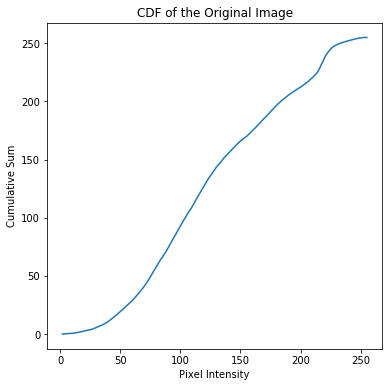

In [88]:
# Plot the cdf of the image
plt.figure(figsize = (6, 6))
plt.plot(cdf_m)
plt.title("CDF of the Original Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Cumulative Sum")
plt.show()

In [89]:
# Convert the reshaped array into an image
histogram_equalized = Image.fromarray(histogram_equalized_array)

## Plot images before and after histogram equalization

<IPython.core.display.Javascript object>


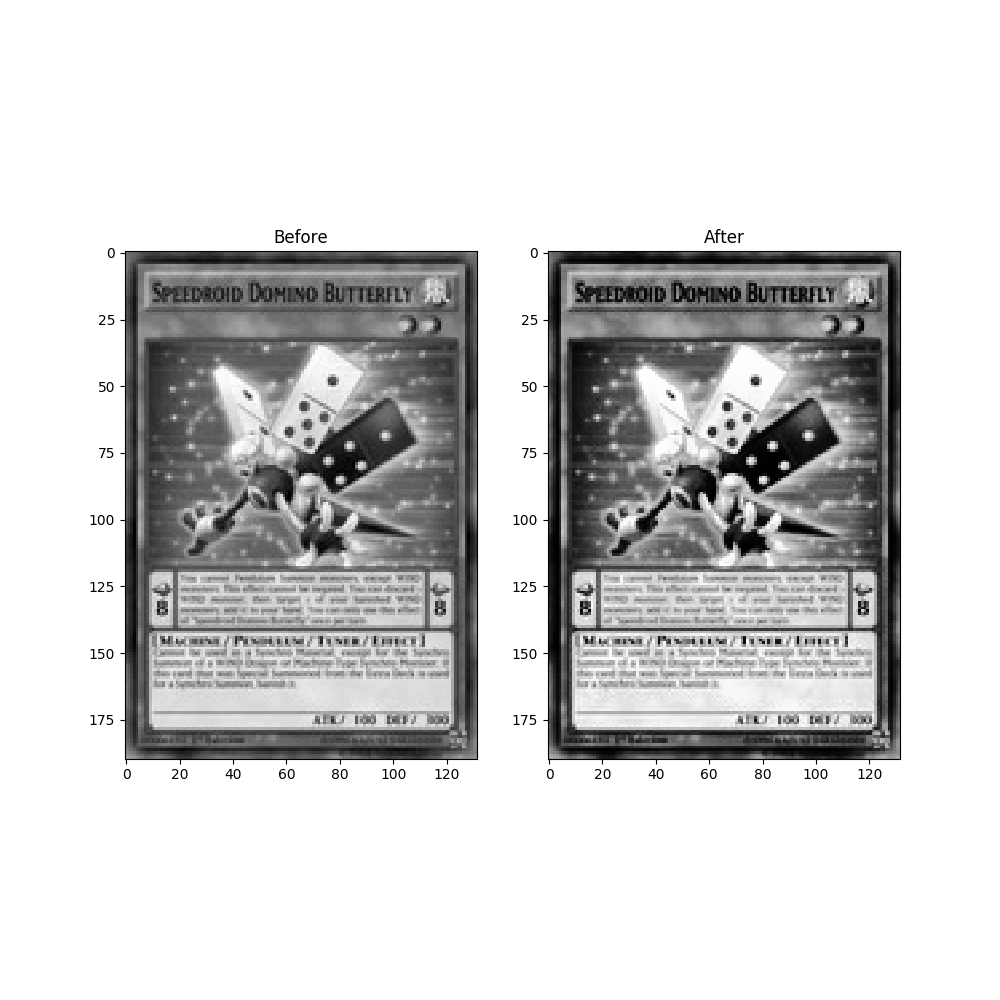

In [239]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
ax[0].imshow(image, cmap = 'gray')
ax[0].title.set_text("Before")

ax[1].imshow(histogram_equalized, cmap = 'gray')
ax[1].title.set_text("After")
plt.show()

## We can see that the distribution of pixel intensities is now much wider this in theory should improve the contrast in the image


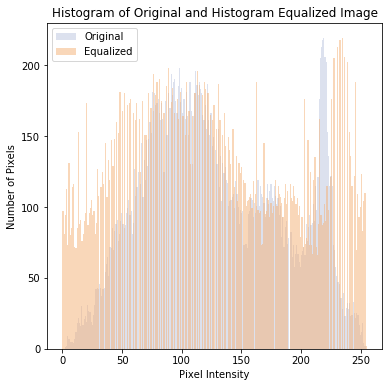

In [100]:
# Plot the histogram of the old image and the new image
plt.figure(figsize = (6, 6))
plt.hist(image_flat, bins = 256, label = 'Original', color = '#BAC4DF', alpha = .5)
plt.hist(histogram_equalized_array.flatten(), bins = 256, label = 'Equalized', color = '#F4B175', alpha = .5)
plt.title("Histogram of Original and Histogram Equalized Image")


plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")

plt.legend()
plt.show()

# Perform Segmentation on the image to prepare the image for character recognition
Adative thresholding divides the image into small sub-images. The threshold values for the sub-images are computed using mean or median or Gaussian methods.

On a sidenote, it looks like segmentation works best with the gamma transformed image. There's less noise around the text especially after the word butterfly.

In [232]:
# Perform the adaptive thresholding
image_thresh = threshold_local(image_gamma_array, block_size = 7, offset = 8, method = 'gaussian')
image_adaptive = image_gamma_array > image_thresh

# Slice out the part of the array that contains the name of the card

<IPython.core.display.Javascript object>


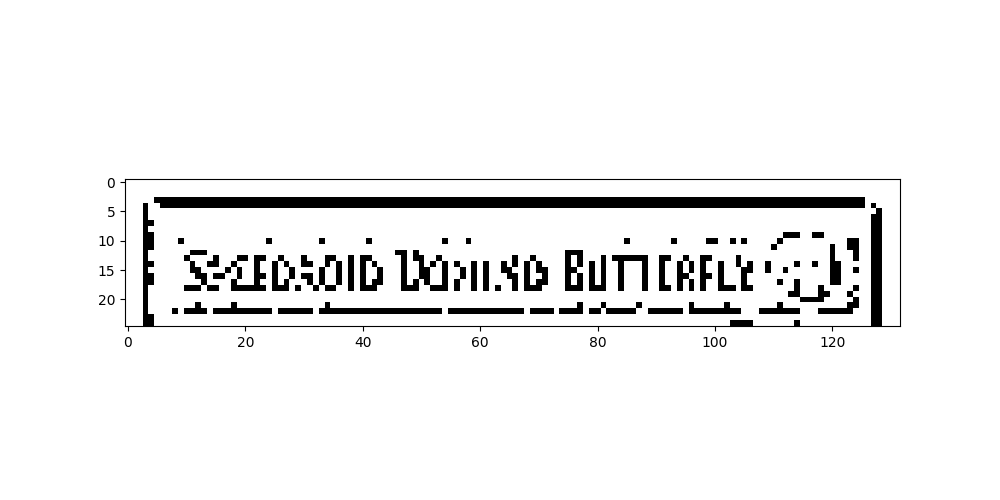

In [233]:
card_name = image_adaptive[0:25]

plt.figure(figsize = (10, 5))
plt.imshow(card_name, cmap = 'gray')
plt.show()